<a href="https://colab.research.google.com/github/dotlincu/project-mnist-classification/blob/main/mnist_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

# bibliotecas para treino, teste e validação, modelo de regressão e avaliação do modelo
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# biblioteca para downsampling de dataset não balanceado
from sklearn.utils import resample

# bibliotecas para avaliação de desempenho dos modelos de classificação
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from scipy.stats import randint
from sklearn.base import clone
from sklearn.svm import SVC
import xgboost as xg

In [3]:
mnist = fetch_openml('mnist_784', as_frame=False)

print(mnist["DESCR"])

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

## Explorando o MNIST dataset

In [4]:
print("Matriz de features: formato ",mnist["data"].shape)
print("Vetor de labels: formato ", mnist["target"].shape)

Matriz de features: formato  (70000, 784)
Vetor de labels: formato  (70000,)


In [5]:
dt=pd.DataFrame(data=mnist["target"].T,columns=["target"])
dt=dt["target"].value_counts()
df=pd.DataFrame()
df["target"]=dt.index.values
df["count"]=dt.values
df["percentage"]=df["count"]/df["count"].sum()
df.round(2)

,target,count,percentage
0,1,7877,0.11
1,7,7293,0.10
2,3,7141,0.10
3,2,6990,0.10
4,9,6958,0.10
5,0,6903,0.10
6,6,6876,0.10
7,8,6825,0.10
8,4,6824,0.10
9,5,6313,0.09


In [6]:
X, y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [7]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [8]:
mnist.data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [9]:
print(X[10])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  42 118 219
 166 118 118   6   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0 103 242 254 254 254 254 254  66   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  18 232
 254 254 254 254 254 238  70   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0 104 244 254 224 254 254 254 141   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0 207 254 210 254 254 254  34   0   0   0   

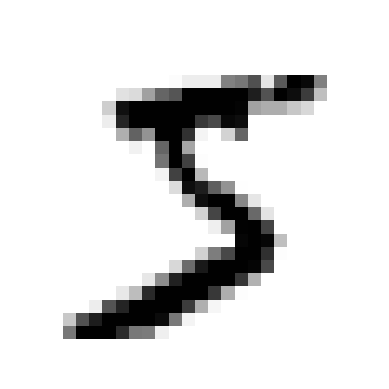

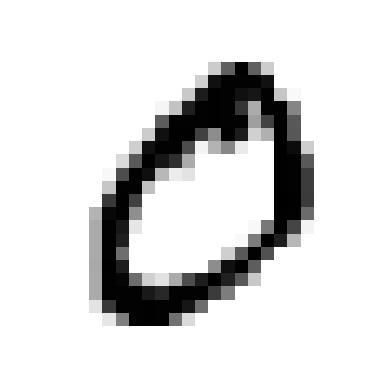

In [10]:
def plot_digit(image_data):
  image = image_data.reshape(28, 28)
  plt.imshow(image, cmap = "binary")
  plt.axis("off")

for i in range(2):
  plot_digit(X[i])
  plt.show()

## Explicação métodos de balanceamento

**Down Sampling (Subamostragem)**

Como funciona?
- Amostras são removidas aleatoriamente da classe majoritária até que ela tenha um tamanho semelhante ao da classe minoritária.
Isso reduz o viés para a classe majoritária.

Vantagens:
- Simples de implementar.
- Ajuda a equilibrar os dados, melhorando a performance em classes minoritárias.

Desvantagens:
- Perde informações importantes, pois remove dados úteis da classe majoritária.
- Pode resultar em um modelo subtreinado para a classe majoritária.

**Over sampling (Sobreamostragem)**

Over sampling aumenta o número de amostras da classe minoritária para equilibrar o conjunto de dados.

Como funciona?
- As amostras da classe minoritária são replicadas aleatoriamente até que o número de exemplos seja próximo ou igual ao da classe majoritária.

Vantagens:
- Mantém todas as amostras da classe majoritária, preservando informações.
- Fornece mais dados para treinar o modelo.

Desvantagens:
- Pode causar overfitting, já que as amostras replicadas são idênticas.
- Não adiciona variabilidade às amostras da classe minoritária.

**SMOTE (Synthetic Minority Oversampling Technique)**

Como funciona?
- Para cada amostra na classe minoritária, encontra os "k" vizinhos mais próximos.
- Gera novos exemplos interpolando entre os pontos existentes.
- O novo ponto é criado no espaço entre um ponto da classe minoritária e um de seus vizinhos.

Vantagens:
- Reduz o risco de overfitting, pois cria novos dados em vez de apenas replicá-los.
- Introduz variabilidade à classe minoritária, melhorando a generalização do modelo.

Desvantagens:
- Pode gerar exemplos irreais ou menos representativos se os dados não forem bem distribuídos.
- Requer mais processamento em comparação com down sampling ou over sampling simples.**negrito**

**Ponderação com Pesos (Class Weighting)**

Como funciona?
- Durante o treinamento, o modelo atribui um custo maior aos erros de classificação da classe minoritária.
- Isso é feito ajustando a função de perda (loss function) para considerar os pesos das classes.
- Por exemplo, em um problema binário, se a classe minoritária tem 10% dos dados e a classe majoritária tem 90%, os pesos podem ser definidos como inversamente proporcionais à frequência das classes (por exemplo, 0.9 para a classe minoritária e 0.1 para a classe majoritária).

Vantagens:
- Preserva os dados originais: Não há perda de informações, como no down sampling, nem replicação de dados, como no over sampling.
- Simples de implementar: Muitos algoritmos de machine learning, como Random Forest, SVM e redes neurais, suportam a atribuição de pesos diretamente.
- Eficiente computacionalmente: Não requer aumento ou redução do conjunto de dados, o que economiza memória e tempo de processamento.

Desvantagens:
- Pode não ser suficiente para desequilíbrios extremos: Em casos de desequilíbrios muito grandes, apenas a ponderação pode não ser suficiente para melhorar a performance do modelo.
- Depende do algoritmo: Nem todos os algoritmos suportam a atribuição de pesos diretamente, o que pode limitar o uso dessa técnica.
- Pode levar a overfitting na classe minoritária: Se os pesos forem mal ajustados, o modelo pode se tornar excessivamente sensível à classe minoritária, prejudicando a generalização.

### Comparação entre as Técnicas

| Técnica               | Vantagens                                                                 | Desvantagens                                                                 |
|-----------------------|---------------------------------------------------------------------------|------------------------------------------------------------------------------|
| **Down Sampling**      | Simples de implementar; reduz o viés para a classe majoritária.           | Perde informações importantes; pode resultar em subtreinamento.             |
| **Over Sampling**      | Mantém todas as amostras; fornece mais dados para treinar o modelo.       | Pode causar overfitting; não adiciona variabilidade.                        |
| **SMOTE**              | Reduz overfitting; introduz variabilidade na classe minoritária.          | Pode gerar exemplos irreais; requer mais processamento.                     |
| **Ponderação com Pesos** | Preserva os dados originais; eficiente computacionalmente.                | Pode não ser suficiente para desequilíbrios extremos; depende do algoritmo. |

---

### Quando Usar Cada Técnica?
- **Down Sampling:** Quando o conjunto de dados é muito grande e o desequilíbrio não é extremo. Útil para reduzir o tempo de processamento.
- **Over Sampling:** Quando o conjunto de dados é pequeno e a classe minoritária precisa de mais exemplos para treinar o modelo.
- **SMOTE:** Quando a classe minoritária precisa de mais variabilidade e o risco de overfitting é uma preocupação.
- **Ponderação com Pesos:** Quando você deseja manter o conjunto de dados original e o algoritmo suporta a atribuição de pesos.

---


[Handling imbalanced dataset in machine learning](https://youtu.be/JnlM4yLFNuo?si=e5Cvcbf_FcHsOvI_)

## Execução do Downsampling

In [11]:
# X e y são a matriz de features e o vetor de labels do dataset
# Realizando downsampling na classe majoritária
X_down, y_down = resample(X[y != '5'], y[y != '5'], replace=False, n_samples=np.sum(y == '5'), random_state=42)

In [12]:
print("Matriz de features: formato ",X_down.shape)
print("Vetor de labels: formato ", y_down.shape)

Matriz de features: formato  (6313, 784)
Vetor de labels: formato  (6313,)


In [13]:
y_down

array(['3', '0', '1', ..., '0', '0', '1'], dtype=object)

In [14]:
# Concatenate the downsampled data with the minority class data
X_balanced = np.concatenate((X_down, X[y == '5']))
y_balanced = np.concatenate((y_down, y[y == '5']))

In [15]:
print("Matriz de features: formato ", X_balanced.shape)
print("Vetor de labels: formato ", y_balanced.shape)

Matriz de features: formato  (12626, 784)
Vetor de labels: formato  (12626,)


In [16]:
y_balanced

array(['3', '0', '1', ..., '5', '5', '5'], dtype=object)

## Divisão do dataset de treino e teste

In [17]:
# Divisão do dataset em 80% de treino e 20% validação :
X_train, X_test, y_train, y_test = train_test_split(X_balanced,y_balanced,
                                       test_size=0.2, # parâmetro da divisão 80/20
                                       shuffle=True,
                                       random_state=42)

print("Matriz de features do dataset de treino:\tformato ", X_train.shape)
print("Vetor de labels do dataset de treino:\t\tformato ", y_train.shape)
print("Matriz de features do dataset de teste:\t\tformato ", X_test.shape)
print("Vetor de labels do dataset de teste:\t\tformato ", y_test.shape)

Matriz de features do dataset de treino:	formato  (10100, 784)
Vetor de labels do dataset de treino:		formato  (10100,)
Matriz de features do dataset de teste:		formato  (2526, 784)
Vetor de labels do dataset de teste:		formato  (2526,)


In [18]:
# True todos os 5s, False para todos os outros dígitos
y_train_5 = (y_train == '5')
y_test_5  = (y_test == '5')

In [19]:
# Tamanho total
y_train_5.shape

(10100,)

In [20]:
# Quantidade de 5's
sum(y_train_5)

5103

## Classificador Binário

### SGDClassifier?

In [21]:
sgd_clf = SGDClassifier(random_state=42)

In [22]:
# Realização da validação cruzada com o método cross_val_score:
sgd_clf_score = cross_val_score(sgd_clf, X_train, y_train_5, cv=5, scoring="accuracy")

In [23]:
print("Acurácia: %.2f"%(sgd_clf_score[0]))
print("Acurácia: %.2f"%(sgd_clf_score[1]))
print("Acurácia: %.2f"%(sgd_clf_score[2]))
print("Acurácia: %.2f"%(sgd_clf_score[3]))
print("Acurácia: %.2f"%(sgd_clf_score[4]))

Acurácia: 0.92
Acurácia: 0.88
Acurácia: 0.91
Acurácia: 0.92
Acurácia: 0.89


In [24]:
"""
Alternativa para realização da validação cruzada com maior controle em cada split/divisão:
"""
# Objeto para criação da validação cruzada com 5 folds:
skfolds = StratifiedKFold(n_splits=5)  # add shuffle=True if the dataset is
                                       # not already shuffled

# Cross-validation com 5 folds:
for train_index, test_index in skfolds.split(X_train, y_train_5):

    clone_clf = clone(sgd_clf) # cria uma cópia do modelo SGD

    # Dataset de treino a partir de train_index
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]

    # Dataset de validação a partir de test_index
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    # treinamento do modelo SGD
    clone_clf.fit(X_train_folds, y_train_folds)

    # Teste de classificação com dataset de validação
    y_pred = clone_clf.predict(X_test_fold)

    # cálculo da acurácia do resultado:
    n_correct = sum(y_pred == y_test_fold)
    print("Acurácia: %.2f"%(n_correct / len(y_pred)))

Acurácia: 0.92
Acurácia: 0.88
Acurácia: 0.91
Acurácia: 0.92
Acurácia: 0.89


In [25]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5)
cm = confusion_matrix(y_train_5, y_train_pred)
print("Matriz de confusão:\n\n",cm)

Matriz de confusão:

 [[4579  418]
 [ 566 4537]]


## 🔹 **Passo a passo do experimento de classificação:**  
1️⃣ **Divisão dos dados** (80% treino, 20% teste)  
2️⃣ **Pré-processamento** (ex.: downsampling do MNIST para balancear as classes)  
3️⃣ **Definição do modelo inicial** (`RandomForestClassifier`)  
4️⃣ **Otimização de hiperparâmetros:**  
   - **Cross-validation (CV)**: Avalia o modelo de forma robusta dividindo os dados em várias partes (ex.: 5-fold).  
   - **RandomizedSearchCV**: Testa combinações aleatórias de hiperparâmetros (rápido e eficiente).  
   - **GridSearchCV**: Após o `RandomizedSearchCV`, pode ser usado para refinar os melhores parâmetros.  
5️⃣ **Treinar o modelo final** com os melhores hiperparâmetros encontrados  
6️⃣ **Avaliação do desempenho:**  
   - Matriz de confusão  
   - Precisão, Revocação, F1-score, ROC-AUC  
   - Curvas de Precisão-Revocação e ROC  
7️⃣ **Teste final** no conjunto de teste  

## 🔥 **Conclusão:**  
Você deve **usar todos os três métodos**:  
✅ **Cross-validation** para avaliar corretamente o modelo.  
✅ **RandomizedSearchCV** para encontrar boas combinações iniciais de hiperparâmetros.  
✅ **GridSearchCV** para refinar os melhores hiperparâmetros encontrados.  

Isso garante um modelo bem otimizado e validado antes de rodar o teste final. 🚀

## RandomForest

In [26]:
# Criação de um pipeline completo com preparação dos dados e modelo de classificação RandomForest:
pipeline = Pipeline([
    ("forest_model", RandomForestClassifier(random_state=42)), # Modelo RandomForest
])

# Definição dos hiperparâmetros para a busca aleatória
param_distributions = [
    # Acesso aos valores dos hiperparâmetros por meio do nome do estágio do pipeline "forest_model"
    {'forest_model__n_estimators': randint(low=80, high=150),       # valores do hiperparâmetro n_estimators
     'forest_model__max_depth': randint(low=5, high=20),            # valores do hiperparâmetro max_depth
     'forest_model__bootstrap': [True, False]},                     # valores do hiperparâmetro bootstrap
]

# Execução de validação cruzada com RandomizedSearch para otimização de hiperparâmetros
rnd_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=10, cv=5,     # 5 folds e 10 iterações
                           scoring='f1_macro',                                      # Métrica de avaliação F1 Macro
                           verbose=3, n_jobs=-1, random_state=42)                   # Multiprocessamento e log detalhado

rnd_search.fit(X_train, y_train_5) # Execução do RandomizedSearchCV

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('forest_model',
                                              RandomForestClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions=[{'forest_model__bootstrap': [True,
                                                                     False],
                                         'forest_model__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fad56b91050>,
                                         'forest_model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fad58253250>}],
                   random_state=42, scoring='f1_macro', verbose=3)

In [27]:
rnd_search.cv_results_

{'mean_fit_time': array([ 5.61184421, 10.54280543,  7.14670787,  8.74591866, 12.79890046,
        14.16988006, 10.99976196, 11.11034527, 10.30287385,  8.7982007 ]),
 'std_fit_time': array([1.15815842, 1.0128822 , 0.79330126, 0.95396212, 2.12363304,
        3.7680495 , 1.16469033, 0.98052928, 0.57255034, 0.74665121]),
 'mean_score_time': array([0.05288143, 0.08248873, 0.06375504, 0.08999853, 0.09075713,
        0.0865829 , 0.08477945, 0.0783515 , 0.08236566, 0.07264814]),
 'std_score_time': array([0.00620174, 0.0082025 , 0.01237416, 0.03620172, 0.03343246,
        0.04105145, 0.02986811, 0.02701811, 0.01276049, 0.00246799]),
 'param_forest_model__bootstrap': masked_array(data=[True, True, True, True, False, False, False, False,
                    True, True],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value=True),
 'param_forest_model__max_depth': masked_array(data=[8, 12, 11, 10, 12, 6, 9, 14, 16, 15],
  

In [28]:
print("Melhores hiperparâmetros: ", rnd_search.best_params_)
print("Melhor F1-score: %.2f"%(rnd_search.best_score_))

Melhores hiperparâmetros:  {'forest_model__bootstrap': False, 'forest_model__max_depth': 14, 'forest_model__n_estimators': 101}
Melhor F1-score: 0.98


In [29]:
# Definição dos hiperparâmetros refinados
param_grid = [
    {'forest_model__n_estimators': [99, 101, 103],    # valores do hiperparâmetro n_estimators
     'forest_model__max_depth': [12, 14, 16],           # valores do hiperparâmetro max_depth
     'forest_model__bootstrap': [False]},                       # valores do hiperparâmetro bootstrap
]

# Execução do GridSearch para busca refinada
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', verbose=3, n_jobs=-1)

grid_search.fit(X_train, y_train_5)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('forest_model',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'forest_model__bootstrap': [False],
                          'forest_model__max_depth': [12, 14, 16],
                          'forest_model__n_estimators': [99, 101, 103]}],
             scoring='f1_macro', verbose=3)

In [34]:
print("Melhores hiperparâmetros: ", grid_search.best_params_)
print("Melhor F1-score: %.2f" % (grid_search.best_score_))

Melhores hiperparâmetros:  {'forest_model__bootstrap': False, 'forest_model__max_depth': 16, 'forest_model__n_estimators': 101}
Melhor F1-score: 0.98


In [31]:
# Criação do DataFrame com os resultados da validação cruzada
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

cv_res["mean_test_score"]=-cv_res["mean_test_score"].values

# Resultados da validação cruzada com intervalo de confiança para média do RMSE:
cv_res[["rank_test_score", "mean_test_score",	"std_test_score",
        "param_forest_model__max_depth","param_forest_model__bootstrap",
        "param_forest_model__n_estimators"]].round(3)

,rank_test_score,mean_test_score,std_test_score,param_forest_model__max_depth,param_forest_model__bootstrap,param_forest_model__n_estimators
7,1,-0.983,0.002,14,False,101
4,2,-0.981,0.002,12,False,109
8,3,-0.981,0.002,16,True,128
9,4,-0.981,0.002,15,True,121
1,5,-0.979,0.002,12,True,140
2,6,-0.979,0.001,11,True,103
3,7,-0.979,0.003,10,True,132
6,8,-0.976,0.003,9,False,112
0,9,-0.971,0.001,8,True,94
5,10,-0.961,0.005,6,False,143


In [32]:
# Criação do DataFrame com os resultados da validação cruzada
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

cv_res["mean_test_score"]=-cv_res["mean_test_score"].values

# Resultados da validação cruzada com intervalo de confiança para média do RMSE:
cv_res[["rank_test_score", "mean_test_score",	"std_test_score",
        "param_forest_model__max_depth","param_forest_model__bootstrap",
        "param_forest_model__n_estimators"]].round(3)

,rank_test_score,mean_test_score,std_test_score,param_forest_model__max_depth,param_forest_model__bootstrap,param_forest_model__n_estimators
7,1,-0.983,0.002,16,False,101
6,2,-0.983,0.002,16,False,99
8,3,-0.983,0.002,16,False,103
4,4,-0.983,0.002,14,False,101
3,5,-0.983,0.001,14,False,99
5,6,-0.982,0.001,14,False,103
1,7,-0.981,0.002,12,False,101
2,8,-0.981,0.002,12,False,103
0,9,-0.981,0.002,12,False,99


In [35]:
# Capturando os melhores valores para os hiperparâmetros:
best_params_bootstrap= grid_search.best_params_["forest_model__bootstrap"]
best_params_max_depth = grid_search.best_params_["forest_model__max_depth"]
best_params_n_estimators = grid_search.best_params_["forest_model__n_estimators"]

# Retreinamento e teste final

In [43]:
# Atualização do modelo com os melhores hiperparâmetros
best_model = RandomForestClassifier(
    n_estimators = best_params_n_estimators,
    max_depth = best_params_max_depth,
    bootstrap = best_params_bootstrap,
    random_state=42
)

# Treinamento do modelo com os melhores hiperparâmetros
best_model.fit(X_train, y_train_5)

# Avaliação do modelo nos dados de teste
y_pred = best_model.predict(X_test)

In [92]:
print(classification_report(y_test_5, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.99      0.99      1316
        True       0.99      0.98      0.98      1210

    accuracy                           0.98      2526
   macro avg       0.99      0.98      0.98      2526
weighted avg       0.98      0.98      0.98      2526



In [87]:
precision = precision_score(y_test_5, y_pred)
recall = recall_score(y_test_5, y_pred)
f1 = f1_score(y_test_5, y_pred)

print(f"Precisão: {precision:.2f}")
print(f"Revocação: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Precisão: 0.99
Revocação: 0.98
F1-score: 0.98


Matriz de confusão:

 [[1302   14]
 [  24 1186]]


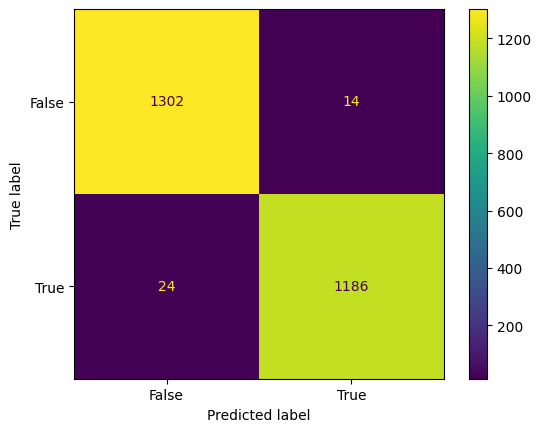

In [80]:
cm = confusion_matrix(y_test_5, y_pred)

print("Matriz de confusão:\n\n", cm)

ConfusionMatrixDisplay.from_predictions(y_test_5, y_pred, values_format="d")
plt.show()

In [81]:
y_scores = cross_val_predict(best_model,
                             X_test, y_test_5, cv=3)

precisions, recalls, thresholds = precision_recall_curve(y_test_5, y_scores)

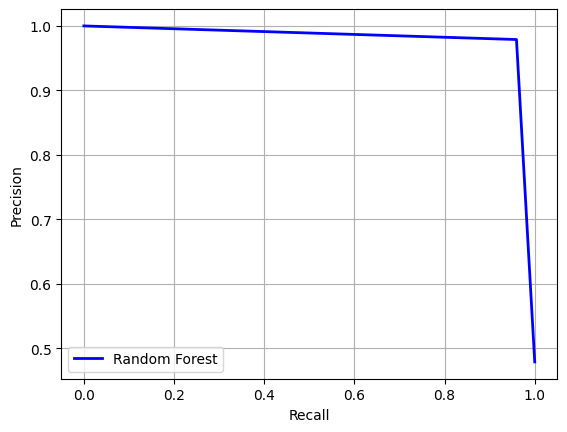

In [82]:
plt.plot(recalls, precisions, "b-", linewidth=2, label="Random Forest")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.legend(loc="lower left")
plt.draw()

In [86]:
# Cálculo da área sob a curva ROC (ROC AUC):
roc_auc = roc_auc_score(y_test_5, y_scores)
print("ROC AUC: %.3f"%roc_auc)

ROC AUC: 0.970


In [89]:
fpr_forest, tpr_forest, thresholds = roc_curve(y_test_5, y_scores)

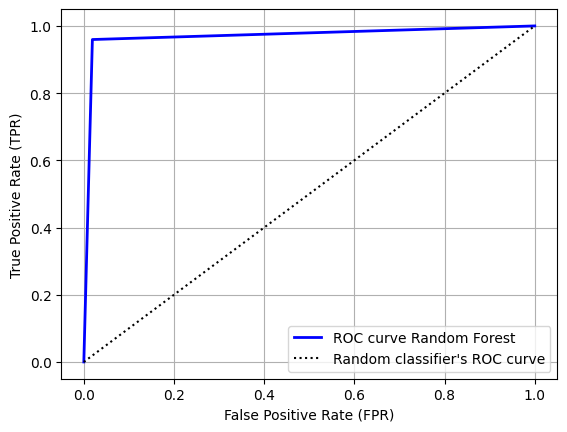

In [90]:
plt.plot(fpr_forest, tpr_forest, "b-", linewidth=2, label="ROC curve Random Forest")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.grid(True)
plt.legend(loc="lower right")
plt.draw()

In [91]:
precision = precision_score(y_test_5, y_pred)
recall = recall_score(y_test_5, y_pred)
f1 = f1_score(y_test_5, y_pred)

print(f"Precisão: {precision:.2f}")
print(f"Revocação: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Precisão: 0.99
Revocação: 0.98
F1-score: 0.98
